In [1]:
import websocket, json
import numpy as np
import pandas as pd
from binance.enums import *
import requests
from datetime import datetime
import config
from binance.client import Client
import time

# DESCARGA DE DATOS
symbol = 'ETHUSDT'
tick_interval = '1m'

def get_candles(start='', symbol=symbol, tick_interval=tick_interval, limit=1000):
    base_url = 'https://api.binance.com/'
    endpoint = 'api/v3/klines?'

    if start:
        query = 'symbol=' + symbol + '&interval=' + tick_interval + '&startTime=' + str(start) + '&limit=' + str(limit)
    else:
        query = 'symbol=' + symbol + '&interval=' + tick_interval + '&limit=' + str(limit)

    candles = requests.get(base_url + endpoint + query).json()

    return candles, candles[-1][6]


def get_all_candles_from_start(symbol, tick_interval):  # devuelve una lista de velas, cada vela es una lista tb
    start = 1502942400000  # 17 de agosto de 2017
    _, last_time = get_candles(start='', symbol=symbol, tick_interval=tick_interval, limit=1)
    candles = []
    while start < last_time:
        i_candles, next_hop = get_candles(start, symbol, tick_interval)
        candles = candles + i_candles
        start = next_hop
    return candles

In [2]:
# DATAFRAME DATOS
candles = get_all_candles_from_start(symbol, tick_interval)
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote', 'trades', 'takers_buy_base',
           'takers_buy_quote', 'ignore']
df = pd.DataFrame(candles, columns=columns)
df = df.sort_values('close_time')
df.drop_duplicates(keep='last')
df = df.astype(float)
closes = df['close'].tolist()

In [3]:
df = df[['open', 'high', 'low', 'close', 'volume', 'trades']]

In [4]:
eth = df
eth['750'] = eth.close.rolling(window = 750).mean()
eth['7505'] = eth['750'].rolling(window = 5).mean()
eth['50'] = eth.close.rolling(window = 50).mean()
eth['R'] = eth.high - eth.low
eth['50R'] = eth.R.rolling(window = 50).mean()
eth['18R'] = eth.R.rolling(window = 18).mean()
eth['9'] = eth.close.rolling(window = 9).mean()
eth['9_y'] = np.where(eth['9'], eth['9'].shift(1),0)
eth['9_2y'] = np.where(eth['9'], eth['9'].shift(2),0)
eth['7505_y'] = np.where(eth['7505'], eth['7505'].shift(1), 0)
eth['next_open'] = np.where(eth['open'], eth['open'].shift(-1), 0)
eth =  eth[150000:]

In [5]:
eth

,open,high,low,close,volume,trades,750,7505,50,R,50R,18R,9,9_y,9_2y,7505_y,next_open
150000,501.99,501.99,501.98,501.98,6.66897,7.0,476.552933,476.475957,500.5778,0.01,2.0452,1.660000,502.512222,502.611111,502.614444,476.436584,501.97
150001,501.97,502.00,501.96,501.96,24.43985,14.0,476.589000,476.514552,500.5324,0.04,2.0210,1.501667,502.453333,502.512222,502.611111,476.475957,501.96
150002,501.96,501.97,500.31,500.38,47.28120,17.0,476.622453,476.551317,500.4598,1.66,2.0158,1.483333,502.374444,502.453333,502.512222,476.514552,501.92
150003,501.92,501.92,500.31,500.45,53.78703,14.0,476.656760,476.587352,500.3672,1.61,1.9946,1.571667,502.122222,502.374444,502.453333,476.551317,501.13
150004,501.13,501.83,499.25,499.40,44.18420,17.0,476.689640,476.622157,500.3028,2.58,1.9794,1.538333,501.621111,502.122222,502.374444,476.587352,499.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543784,1212.16,1213.36,1210.23,1213.35,3224.94440,1361.0,1162.312667,1162.141387,1214.0932,3.13,2.6570,2.668333,1214.260000,1214.631111,1215.258889,1162.055189,1213.36
2543785,1213.36,1213.46,1211.06,1211.58,1688.65720,716.0,1162.391960,1162.225853,1214.1356,2.40,2.6648,2.719444,1213.804444,1214.260000,1214.631111,1162.141387,1211.58
2543786,1211.58,1212.57,1211.40,1212.08,1829.29700,807.0,1162.471840,1162.309008,1214.1582,1.17,2.6480,2.491111,1213.475556,1213.804444,1214.260000,1162.225853,1212.08
2543787,1212.08,1214.04,1211.79,1212.64,643.51090,728.0,1162.553360,1162.391288,1214.1954,2.25,2.6446,2.366667,1213.255556,1213.475556,1213.804444,1162.309008,1212.63


In [6]:
ON_HOLD = False
bought = False
bars = 0
bought_at = 0
sold_at = 0
top = 0
bought_when = []
sold_when = []
duration_pos = []
duration_neg = []
y_curve = []
max_profit_pos = []
max_profit_neg = []
obj_count = 0
thresh_pos = []
thresh_neg = []

for row in eth.iterrows():
    close = row[1]['close']
    nine = row[1]['9']
    nine_y = row[1]['9_y']
    nine_2y = row[1]['9_2y']
    next_open = row[1]['next_open']
    fifty_range = row[1]['50R']
    
    if (ON_HOLD == True) & (bought == False) & (nine < nine_y):
        ON_HOLD = False
        
    if (ON_HOLD == False) & (bought == False):
        svn_5 = row[1]['7505']
        svn_5y = row[1]['7505_y']
        fifty = row[1]['50']
        
        #& (((nine - fifty)/fifty) < 0.004)
        if (svn_5 > svn_5y) & (nine_2y > nine_y) & (nine > nine_y):
            ON_HOLD = True
            if close > nine:
                bought = True
                bars = 1
                
                bought_at = next_open
                bought_when.append(row[0])
                obj = bought_at + (1.5 * fifty_range)
                stop = bought_at - (1.5 * fifty_range)
                ON_HOLD = False
        
    elif (ON_HOLD == True) & (close > nine) & (bought == False):
        bought = True
        bars = 1
        
        bought_at = next_open
        bought_when.append(row[0])
        obj = bought_at + (1.5 * fifty_range)
        stop = bought_at - (1.5 * fifty_range)
        ON_HOLD = False
        
    elif (ON_HOLD == False) & (bought == True):
        bars += 1
        high = row[1]['high']
        low = row[1]['low']
        
        if (bars == 4):
            new_stop = bought_at - ((bought_at - stop)/2)
            if close > new_stop:
                if new_stop < stop:
                    stop = stop
                else:
                    stop = new_stop               
            elif close < new_stop:
                sold_at = next_open
                sold_when.append(row[0])
                bought = False
                bars = 0
                if high > obj:
                    obj_count += 1
                x = sold_at/bought_at
                y = top/bought_at
                z = sold_when[-1] - bought_when[-1]
                y_curve.append(x)
                if x >= 1.0:
                    max_profit_pos.append(y)
                    duration_pos.append(z)
                    thresh_pos.append(obj_count)
                elif x < 1.0:
                    max_profit_neg.append(y)
                    duration_neg.append(z)
                    thresh_neg.append(obj_count)
                top = 0
                obj_count = 0
            
        if (bars == 8):
            if (close > bought_at):
                stop = bought_at
            elif (close < bought_at):
                sold_at = next_open
                sold_when.append(row[0])
                bought = False
                bars = 0
                if high > obj:
                    obj_count += 1
                x = sold_at/bought_at
                y = top/bought_at
                z = sold_when[-1] - bought_when[-1]
                y_curve.append(x)
                if x >= 1.0:
                    max_profit_pos.append(y)
                    duration_pos.append(z)
                    thresh_pos.append(obj_count)
                elif x < 1.0:
                    max_profit_neg.append(y)
                    duration_neg.append(z)
                    thresh_neg.append(obj_count)
                top = 0
                obj_count = 0
                
        if bought == True:
            if high > top:
                top = high
                
            if (low < stop):
                sold_at = stop
                sold_when.append(row[0])
                bought = False
                bars = 0
                if high > obj:
                    obj_count += 1
                x = sold_at/bought_at
                y = top/bought_at
                z = sold_when[-1] - bought_when[-1]
                y_curve.append(x)
                if x >= 1.0:
                    max_profit_pos.append(y)
                    duration_pos.append(z)
                    thresh_pos.append(obj_count)
                elif x < 1.0:
                    max_profit_neg.append(y)
                    duration_neg.append(z)
                    thresh_neg.append(obj_count)
                top = 0
                obj_count = 0

            elif high > obj:
                obj = close + (1.5 * fifty_range)
                if (close - (1.5 * fifty_range) < stop):
                    stop = stop
                else:
                    stop = close - (1.5 * fifty_range)
                obj_count += 1

In [7]:
print(min(y_curve))
print(max(y_curve))

0.9756578125
1.0965216357584402


In [8]:
mec = []
for i, v in enumerate(thresh_neg):
    if v == 1:
        if duration_neg[i] >= 8:
            mec.append(duration_neg[i])
print(len(mec))

30


In [9]:
pos = 0
neg = 0
for y in y_curve:
    if y > 1.0:
        pos += 1
    elif y < 1.0:
        neg += 1
print(f'Positive Trades: {pos}')
print(f'Negative Trades: {neg}')

pos_ = []
neg_ =  []
neut = 0
for y in y_curve:
    if y > 1.0:
        pos_.append(y)
    elif y < 1.0:
        neg_.append(y)

distribution_t_neg = {}
count = 0
x = range(min(thresh_neg), max(thresh_neg) + 1)
for j in x:
    for i in thresh_neg:
        if i == j:
            count += 1
    distribution_t_neg[str(j)] = count
    count = 0

distribution_t_pos = {}
count = 0
x = range(min(thresh_pos), max(thresh_pos) + 1)
for j in x:
    for i in thresh_pos:
        if i == j:
            count += 1
    distribution_t_pos[str(j)] = count
    count = 0

steps = np.arange(0.96, 1.1, 0.0005)
count = 0
distribution = {}
for i, v in enumerate(steps):
    for y in y_curve:
        if i == 0:
            if y < v:
                count += 1
        else:
            if (y > steps[i - 1]) & (y < steps[i]):
                count += 1
    distribution[f'{round(steps[i - 1],4)}-{round(steps[i], 4)}'] = count
    count = 0 
    
print(f'Mean Return Positive Trades: {round((np.mean(pos_) - 1)*100, 5)}%')
print(f'Mean Return Negative Trades: {round((np.mean(neg_) - 1)*100, 5)} %')
print(f'Mean Return from Buy Price to Highest Point in All POSITIVE Movements: {round((np.mean(max_profit_pos) - 1)*100, 5)} %')
print(f'Same with All NEGATIVES: {round((np.mean(max_profit_neg) - 1)*100, 5)} %')
print(f'Mean Duration of Positive Trades: {round(np.mean(duration_pos), 2)}')
print(f'Mean Duration of Negative Trades: {round(np.mean(duration_neg), 2)}')

Positive Trades: 12239
Negative Trades: 35848
Mean Return Positive Trades: 0.43519%
Mean Return Negative Trades: -0.14343 %
Mean Return from Buy Price to Highest Point in All POSITIVE Movements: 0.55377 %
Same with All NEGATIVES: 0.0856 %
Mean Duration of Positive Trades: 15.18
Mean Duration of Negative Trades: 3.78


In [10]:
curve = []
count = 0
capital = 10000
for i in range(0, len(eth)):
    if (sold_when[count] == eth.index[i]) & (count < len(y_curve) - 1):
        curve.append(y_curve[count])
        count += 1
    else:
        curve.append(1)
        
EC = []
z = 10000
for x in curve:
    z += (capital * x) - capital
    EC.append(z)

In [11]:
BH = []
capital = 10000
for row in eth.iterrows():
    close = row[1]['close']
    x = close/eth['close'][150000]
    y = capital * x
    BH.append(y)

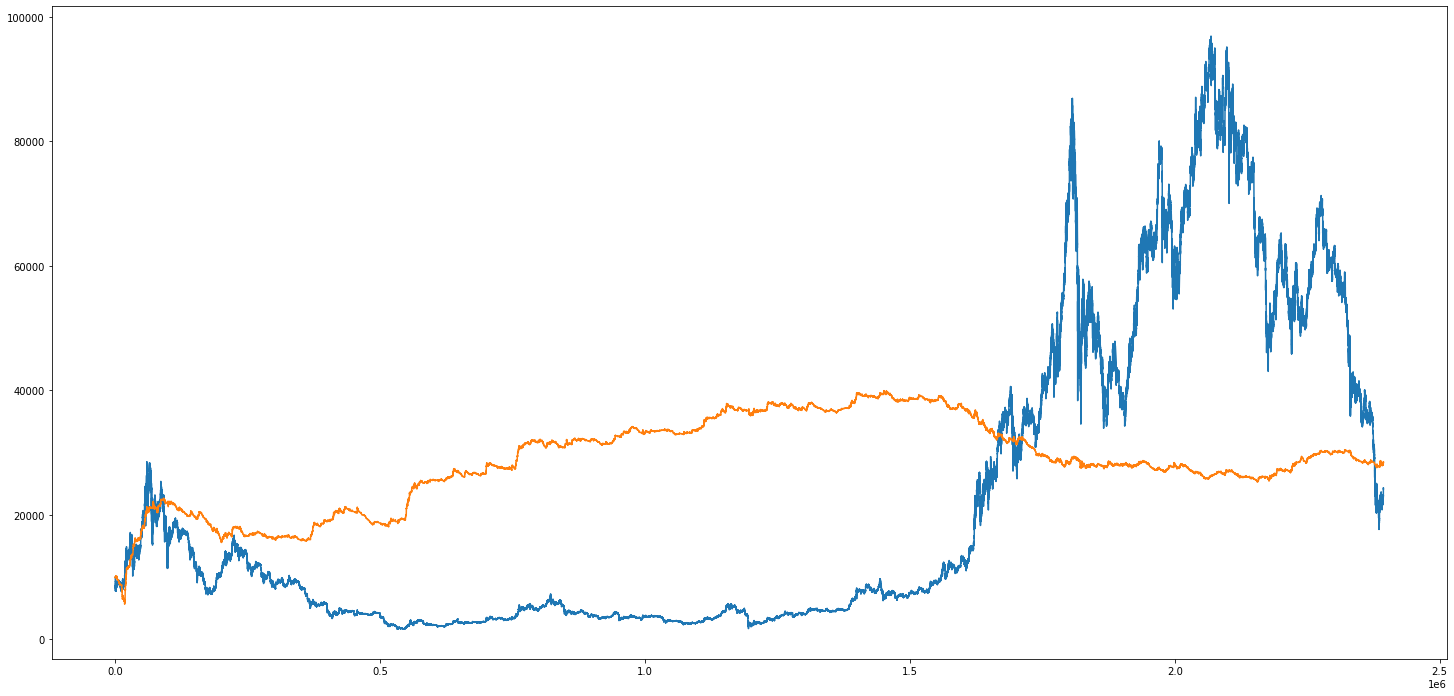

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (25,12))
plt.plot(BH)
plt.plot(EC)